In [ ]:
import requests
import zipfile
import os
from google.colab import drive
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
import re
import numpy as np



In [ ]:
pd.set_option('display.max_columns', None)  # show all columns
pd.set_option('display.width', 200)         # adjust based on terminal width
pd.set_option('display.float_format', '{:.3f}'.format)  # float precision

In [ ]:
# Mount Google Drive
drive.mount('/content/gdrive')

# Load the dataset (Excel file)
file_path = '/content/gdrive/My Drive/Specialedatav2.csv'
df = pd.read_csv(file_path)

Mounted at /content/gdrive


In [ ]:
# prompt: delete the events where score is na

df = df.dropna(subset=['scores'])
df = df[df['scores'] > 95]
df = df[df.result_id != 2]
df.loc[df['bodypart_name'].str.contains('foot', case=False, na=False), 'bodypart_name'] = 'foot'
df = df[df.bodypart_name == "foot"]

In [ ]:
len(df)

146911

In [ ]:
# Extract player IDs from the column names
player_ids = sorted(set([col.split('_')[0] for col in df.columns if re.match(r'\d+_x', col)]))

def row_to_matrix(row):
    players = []
    ball_team = row['ball_owning_team_id']
    for pid in player_ids:
        if not (pd.isna(row[f'{pid}_x']) or pd.isna(row[f'{pid}_y'])):
            x = row[f'{pid}_x']
            y = row[f'{pid}_y']
            s = row[f'{pid}_s']
            player_team = row[f'{pid}_teamid']
            team_indicator = 1 if player_team == ball_team else 0
            players.append([x, y, s, team_indicator])
    return np.array(players)

# Apply it
df['player_matrix'] = df.apply(row_to_matrix, axis=1)

In [ ]:
import numpy as np
import ast

def get_teammates_positions(player_matrix):
    """
    Extract the positions of all teammates (team_indicator == 1) from the player matrix.
    """
    return [(x, y) for x, y, s, team_indicator in player_matrix if team_indicator == 1]

def project_point_on_line(px, py, x1, y1, x2, y2):
    """
    Projects a point (px, py) onto the line segment defined by (x1, y1) -> (x2, y2).
    Returns the closest point on the segment to (px, py).
    """
    line_vec = np.array([x2 - x1, y2 - y1])  # Direction vector of the pass
    point_vec = np.array([px - x1, py - y1])  # Vector from start to player
    line_len = np.dot(line_vec, line_vec)  # Squared length of line

    if line_len == 0:
        return x1, y1  # Start and end are the same (shouldn't happen)

    t = np.dot(point_vec, line_vec) / line_len  # Projection scalar
    t = max(0, min(1, t))  # Clamp to the segment range

    # Compute the closest point on the segment
    proj_x = x1 + t * line_vec[0]
    proj_y = y1 + t * line_vec[1]

    return proj_x, proj_y

def get_intended_end_coordinates(start_x, start_y, pass_angle, teammates_positions, actual_end_x, actual_end_y, alpha=0.33):
    """
    Finds the teammate who is most likely the intended recipient of the pass.
    Considers both proximity to the pass trajectory and the actual pass end location.

    Parameters:
    - start_x, start_y: start location of the pass
    - pass_angle: angle of the intended pass
    - teammates_positions: list of (x, y) tuples for teammates
    - actual_end_x, actual_end_y: where the pass actually ended
    - alpha: weighting factor between projection distance and end-point distance (0 <= alpha <= 1)
    """
    max_pass_length = 50
    end_x = start_x + max_pass_length * np.cos(pass_angle)
    end_y = start_y + max_pass_length * np.sin(pass_angle)

    min_score = float('inf')
    intended_end = (end_x, end_y)  # Default fallback

    for teammate_x, teammate_y in teammates_positions:
        # Distance to projected trajectory
        proj_x, proj_y = project_point_on_line(teammate_x, teammate_y, start_x, start_y, end_x, end_y)
        dist_to_trajectory = np.hypot(teammate_x - proj_x, teammate_y - proj_y)

        # Distance to actual end point
        dist_to_actual_end = np.hypot(teammate_x - actual_end_x, teammate_y - actual_end_y)

        # Weighted score
        score = alpha * dist_to_trajectory + (1 - alpha) * dist_to_actual_end

        if score < min_score:
            min_score = score
            intended_end = (teammate_x, teammate_y)

    return intended_end

def update_intended_end_coordinates(row):
    """
    Determines intended_end_coordinates:
    - Successful passes: Use actual end_coordinates.
    - Failed passes: Assign to the closest teammate along the pass trajectory.
    """
    start_x, start_y = ast.literal_eval(row['start_coordinates'])
    end_x, end_y = ast.literal_eval(row['end_coordinates'])
    pass_angle = row['pass_angle']  # Angle in radians
    teammates_positions = get_teammates_positions(row['player_matrix'])

    if row['result_id'] == 0:  # Failed pass
        intended_end_coordinates = get_intended_end_coordinates(start_x, start_y, pass_angle, teammates_positions, end_x, end_y)
    else:  # Successful pass
        intended_end_coordinates = ast.literal_eval(row['end_coordinates'])

    return intended_end_coordinates

# Apply function to DataFrame
df['intended_end_coordinates'] = df.apply(update_intended_end_coordinates, axis=1)

In [ ]:
import numpy as np
import ast

# Function to compute the Euclidean distance
def compute_pass_distance(row):
    start_x, start_y = ast.literal_eval(row['start_coordinates'])
    end_x, end_y = (row['intended_end_coordinates'])
    return np.sqrt((end_x - start_x) ** 2 + (end_y - start_y) ** 2)

# Apply the function to create the new 'pass_distance' column
df['pass_distance'] = df.apply(compute_pass_distance, axis=1)

# Stack distances into a NumPy array
pass_distances = df['pass_distance'].values.reshape(-1, 1)  # Reshape to (num_samples, 1)

In [ ]:
dftest = df[df['original_event_id'] == 2610391575]

In [ ]:
dftest

,Unnamed: 0,original_event_id,team_id_x,period_id_x,matched_frames,scores,game_id,period_id_y,time_seconds,team_id_y,...,431799_s,487260_x,487260_y,487260_teamid,487260_s,start_coordinates,end_coordinates,player_matrix,intended_end_coordinates,pass_distance
104054,558,2610391575,2450.0,1.0,37639,99.106539,2367407,1,2683.0,2450,...,NaN,NaN,NaN,NaN,NaN,"(1.0, 66.3)","(68.1, 46.9)","[[17.735890410958902, 42.95490909090909, 2.69,...","(46.350819672131145, 44.13090909090909)",50.479357


In [ ]:
ready_df = pd.DataFrame()

In [ ]:
ready_df = df[['game_id', 'original_event_id', 'player_id', 'player_name', 'starting_position', 'start_coordinates', 'end_coordinates', 'intended_end_coordinates', 'pass_distance', 'pass_angle', 'player_matrix', 'result_id']].copy()

#Pressure

In [ ]:
def calculate_pressure_feature(row):
    start_x, start_y = ast.literal_eval(row["start_coordinates"])  # Passer position
    end_x, end_y = ast.literal_eval(row["end_coordinates"])  # Receiver position (already tuple)
    player_matrix = np.array(row["player_matrix"])  # Extract player positions

    # Filter opponents (team == 0)
    opponent_players = player_matrix[player_matrix[:, 3] == 0]  # Columns: [x, y, speed, team]

    # Compute distances to all opponents for passer and receiver
    distances_passer = np.linalg.norm(opponent_players[:, :2] - np.array([start_x, start_y]), axis=1)
    distances_receiver = np.linalg.norm(opponent_players[:, :2] - np.array([end_x, end_y]), axis=1)

    closest_opponent_distance_passer = np.min(distances_passer) if len(distances_passer) > 0 else np.nan
    closest_opponent_distance_receiver = np.min(distances_receiver) if len(distances_receiver) > 0 else np.nan

    # Initialize values for trajectory calculations
    num_opponents_near_trajectory = 0
    min_trajectory_distance = float('inf')
    closest_trajectory_opponent = None

    # Check all opponents relative to the pass trajectory
    for opp_x, opp_y in opponent_players[:, :2]:
        proj_x, proj_y = project_point_on_line(opp_x, opp_y, start_x, start_y, end_x, end_y)
        distance_to_trajectory = np.sqrt((opp_x - proj_x) ** 2 + (opp_y - proj_y) ** 2)

        if distance_to_trajectory < 2:
            num_opponents_near_trajectory += 1

        if distance_to_trajectory < min_trajectory_distance:
            min_trajectory_distance = distance_to_trajectory
            closest_trajectory_opponent = (opp_x, opp_y)

    return (
        closest_opponent_distance_passer,
        closest_opponent_distance_receiver,
        num_opponents_near_trajectory,
        closest_trajectory_opponent,
        min_trajectory_distance
    )


In [ ]:
ready_df[[
    "pressure_distance_passer",
    "pressure_distance_receiver",
    "num_opponents_near_trajectory",
    "closest_opponent_to_trajectory",
    "distance_from_opponent_closest_to_trajectory"
]] = ready_df.apply(lambda row: pd.Series(calculate_pressure_feature(row)), axis=1)


# Model training

In [ ]:
len(ready_df)

146911

In [ ]:
from sklearn.model_selection import train_test_split
ready_df, test_df = train_test_split(
    ready_df,
    test_size=0.2,
    random_state=42,
    shuffle=True)

In [ ]:
test_df.to_csv("/content/gdrive/MyDrive/fixedtestdatav12.csv")

In [ ]:
import numpy as np
import ast

# Create the pass feature vector
ready_df['pass_features'] = ready_df.apply(
    lambda row: list(ast.literal_eval(row['start_coordinates'])) +
                list((row['intended_end_coordinates'])) + # removed ast.literal_eval when using intended_end_coordinates
                [row['pass_distance']] +
                [row['pass_angle']] +
                [row['pressure_distance_passer']] +
                [row['pressure_distance_receiver']] +
                [row['num_opponents_near_trajectory']],
    axis=1
)

# The 'player_matrix' column likely already contains NumPy arrays
ready_df['player_matrix_array'] = ready_df['player_matrix'].apply(lambda x: np.array(x))

# Pad shorter arrays with zeros to match the maximum shape
max_players = 22  # Expected number of players
padded_matrices = [
    np.pad(arr, ((0, max_players - arr.shape[0]), (0, 0)), 'constant')
    if arr.shape[0] < max_players else arr
    for arr in ready_df['player_matrix_array']
]

# Stack player matrices and pass features into NumPy arrays
player_matrices = np.stack(padded_matrices)  # Shape: (num_samples, 22, 4)
pass_features = np.stack(ready_df['pass_features'].values)          # Shape: (num_samples, 9)

# Target variable (0 or 1)
targets = ready_df['result_id'].values

In [ ]:
train_p, val_p, train_f, val_f, train_y, val_y = train_test_split(
    player_matrices,
    pass_features,
    targets,
    test_size=0.25,
    random_state=42
)

In [ ]:
len(ready_df)

117528

In [ ]:
len(train_p)

88146

In [ ]:
import tensorflow as tf

BATCH_SIZE = 256

train_ds = tf.data.Dataset.from_tensor_slices(((train_p, train_f), train_y)).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
val_ds = tf.data.Dataset.from_tensor_slices(((val_p, val_f), val_y)).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)


In [ ]:
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.003,
    decay_steps=12876, #To hit default 0.001 after 800 epochs
    decay_rate=0.95,
    staircase=True
)

optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models

# ---- Player matrix input ----
player_input = layers.Input(shape=(22, 4), name='player_matrix')

# Multi-head self-attention (players attend to each other)
attn_output = layers.MultiHeadAttention(num_heads=4, key_dim=4)(player_input, player_input)

# Residual connection + normalization
attn_output = layers.Add()([attn_output, player_input])
attn_output = layers.LayerNormalization()(attn_output)

# Optional: Add feed-forward layer (like a Transformer block)
ff = layers.Dense(64, activation='relu')(attn_output)
ff = layers.Dense(4)(ff)  # Project back to original feature dim (4)
attn_output = layers.Add()([attn_output, ff])
attn_output = layers.LayerNormalization()(attn_output)

# Pool player representations (global context)
player_summary = layers.GlobalAveragePooling1D()(attn_output)

# ---- Pass feature input ----
pass_input = layers.Input(shape=(9,), name='pass_features')
pass_dense = layers.Dense(64, activation='relu')(pass_input)

# ---- Combine player and pass data ----
combined = layers.Concatenate()([player_summary, pass_dense])
x = layers.Dense(64, activation='relu')(combined)
x = layers.Dropout(0.2)(x)
x = layers.Dense(32, activation='relu')(x)
#x = layers.Dropout(0.2)(x)

# ---- Output ----
output = layers.Dense(1, activation='sigmoid')(x)

# ---- Build and compile ----
attention_model = models.Model(inputs=[player_input, pass_input], outputs=output)

attention_model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)


In [ ]:
from tensorflow.keras.utils import model_to_dot

dot = model_to_dot(
    attention_model,
    show_shapes=True,
    show_layer_names=True,
    expand_nested=True,
    dpi=100
)

for node in dot.get_nodes():
    node.set_fillcolor('#003366')  # dark blue
    node.set_style('filled')
dot.write_png('/content/gdrive/MyDrive/modelp22lot.png')


FileNotFoundError: [Errno 2] No such file or directory: '/content/gdrive/MyDrive/modelp22lot.png'

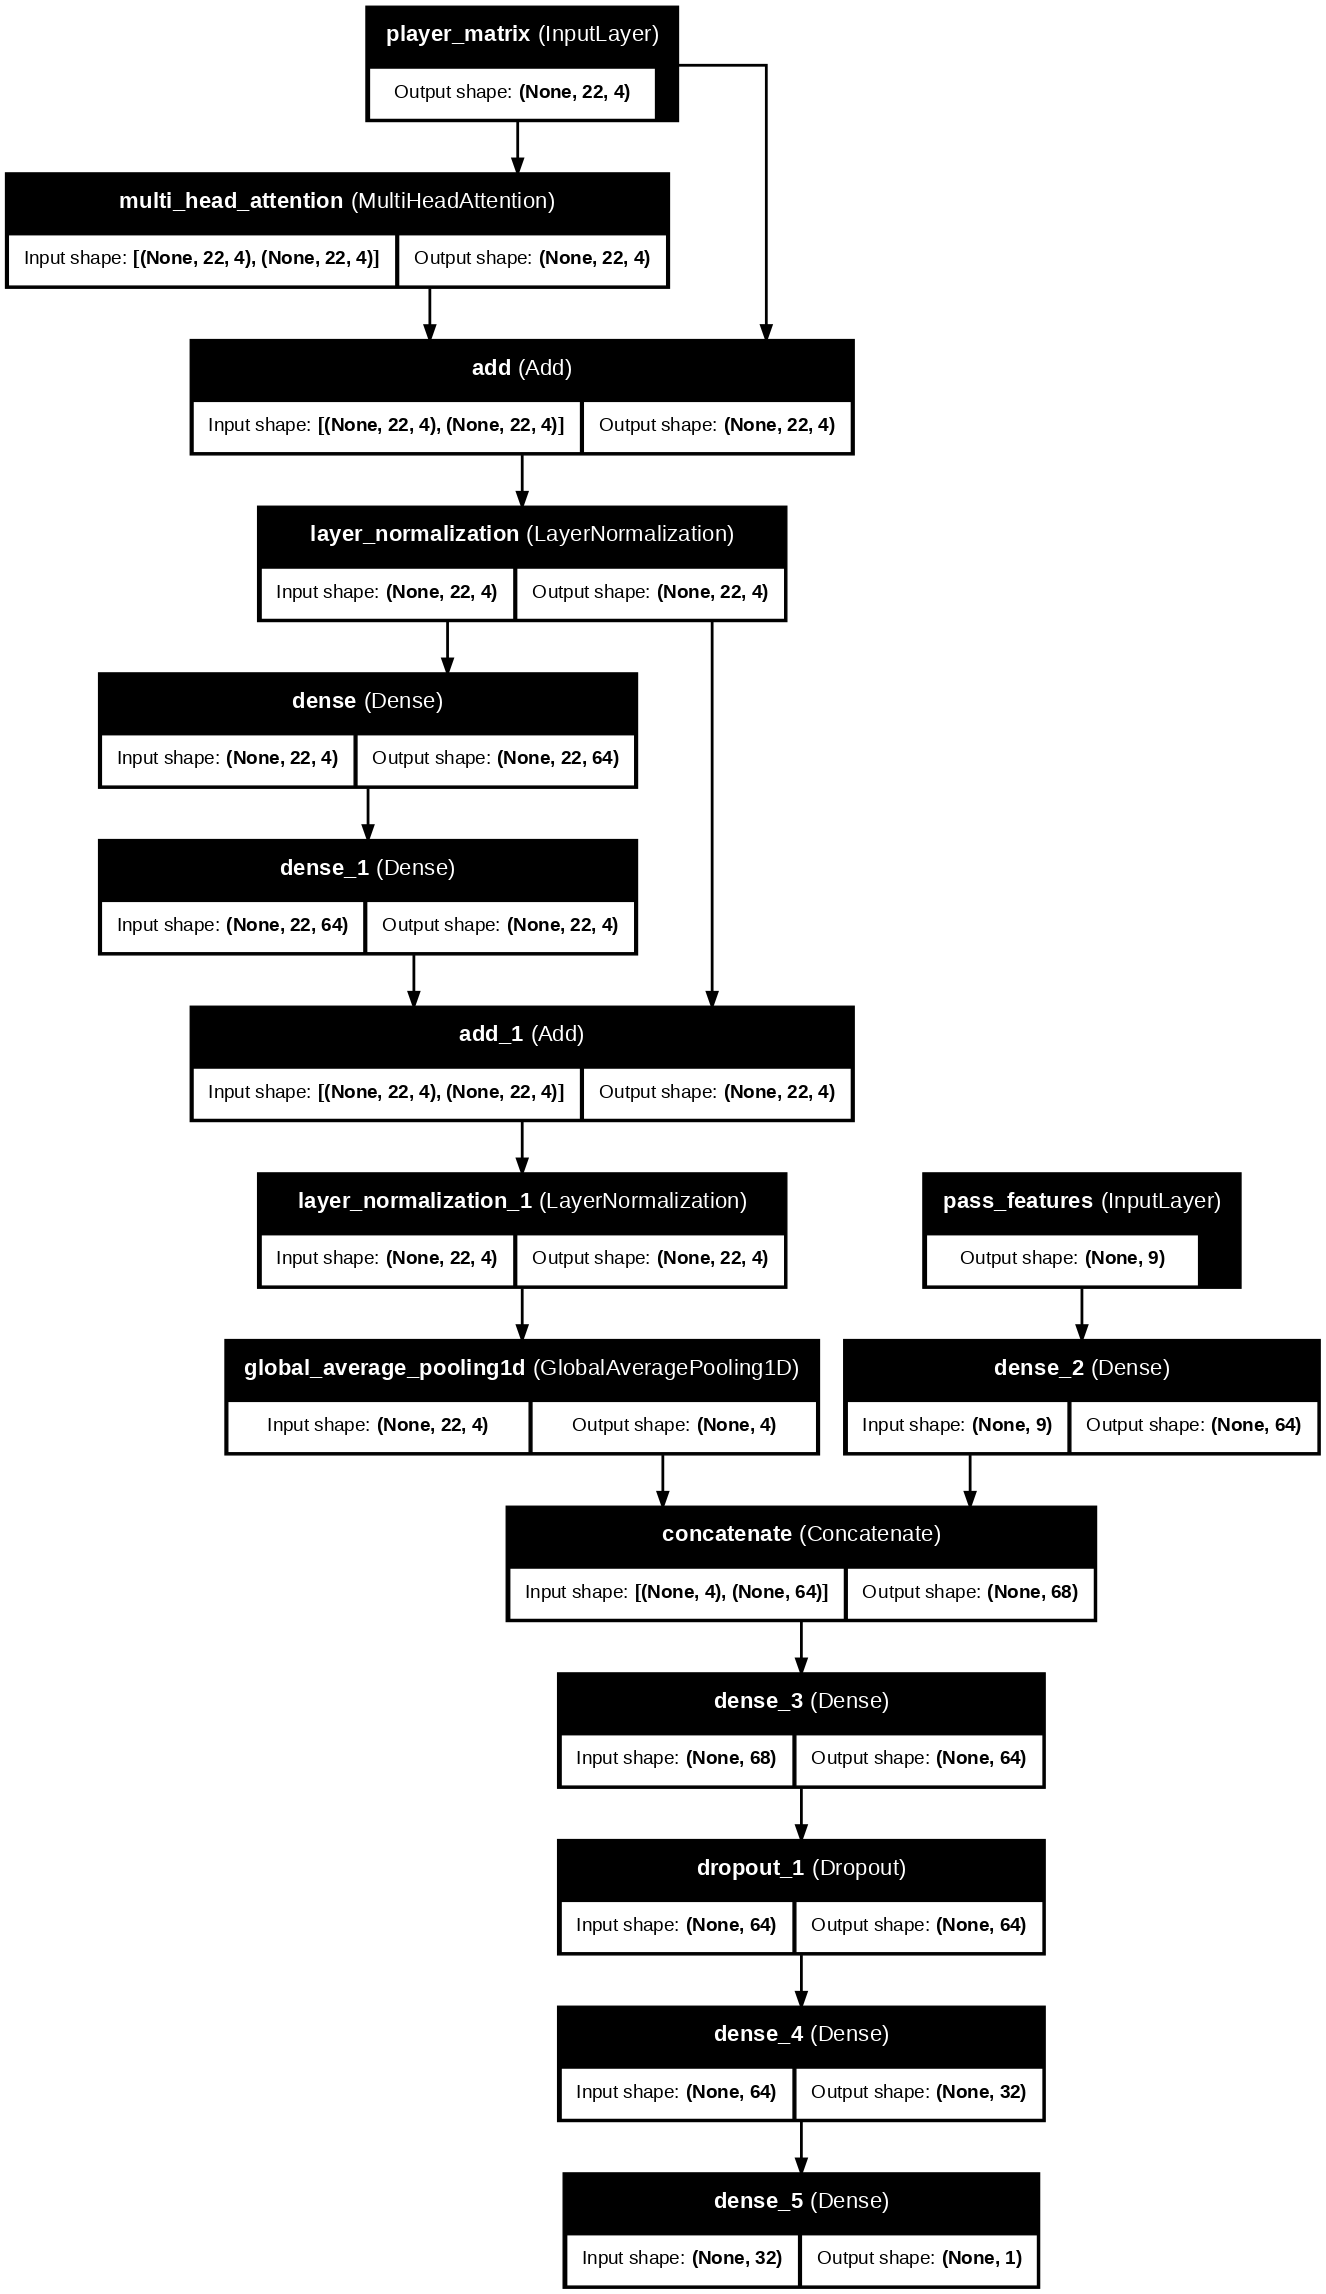

In [ ]:
from tensorflow.keras.utils import plot_model

plot_model(
    attention_model,
    to_file='/content/gdrive/MyDrive/modelplot.png',
    show_shapes=True,
    show_layer_names=True,
    expand_nested=True,
    dpi=100
)


/usr/local/lib/python3.11/dist-packages/visualkeras/layered.py:86: UserWarning: The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.
  warnings.warn("The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.")


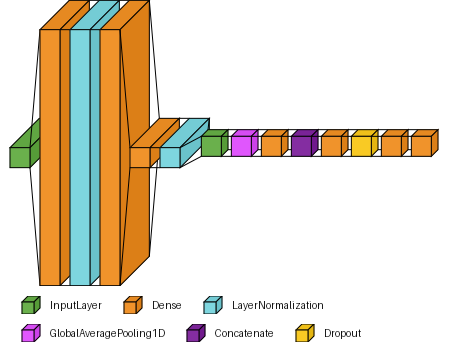

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
import visualkeras
from collections import defaultdict
from PIL import ImageFont

# ---- Dummy Model for Visualization ----
# Player input layer
player_input = layers.Input(shape=(22, 4), name='player_input')

# Simulate the attention mechanism with dummy layers (e.g., Dense)
attn_output = layers.Dense(64, activation='relu', name='multihead_attention_placeholder')(player_input)
attn_output = layers.LayerNormalization(name='attn_norm_1')(attn_output)

# Feed-forward simulation
ff = layers.Dense(64, activation='relu', name='ff_dense_1')(attn_output)
ff = layers.Dense(4, name='ff_dense_2')(ff)
attn_output = layers.LayerNormalization(name='attn_norm_2')(ff)

# Global Pooling to simulate player data pooling
player_summary = layers.GlobalAveragePooling1D(name='player_pooling')(attn_output)

# Pass input layer (simulated path)
pass_input = layers.Input(shape=(9,), name='pass_input')

# Simulate pass feature processing (e.g., Dense layer)
pass_dense = layers.Dense(64, activation='relu', name='pass_dense')(pass_input)

# Combine the player and pass data
combined = layers.Concatenate(name='combine_input')([player_summary, pass_dense])

# Simulate fully connected layers
x = layers.Dense(64, activation='relu', name='combined_dense_1')(combined)
x = layers.Dropout(0.2, name='dropout')(x)
x = layers.Dense(32, activation='relu', name='combined_dense_2')(x)

# Output layer for binary classification (simulated)
output = layers.Dense(1, activation='sigmoid', name='output')(x)

# ---- Create the Model ----
# Define the model with two inputs: player and pass inputs
attention_model = models.Model(inputs=[player_input, pass_input], outputs=output)

# ---- Visualize the Dummy Model ----
# Create a color map for different layers
color_map = defaultdict(dict)
color_map[layers.InputLayer]['fill'] = '#6ab04c'
color_map[layers.Dense]['fill'] = '#f0932b'
color_map[layers.Dropout]['fill'] = '#f9ca24'
color_map[layers.LayerNormalization]['fill'] = '#7ed6df'
color_map[layers.GlobalAveragePooling1D]['fill'] = '#e056fd'


# Visualize the model with dummy layers and inputs and display layer names
visualkeras.layered_view(
    attention_model,
    to_file='/content/gdrive/MyDrive/modelplot23.png',
    color_map=color_map,
    draw_volume=True,  # Display volumes of layers
    type_ignore=[visualkeras.SpacingDummyLayer],
    legend=True  # Correct argument to show layer names
)


In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint

# Define the callback
checkpoint_cb = ModelCheckpoint(
    "/content/gdrive/MyDrive/best_modelfixeddatav13.keras",  # <-- Full path to Google Drive
    save_best_only=True,
    monitor='val_loss',
    mode='min',
    verbose = 0
)


In [ ]:
history13 = attention_model.fit(
    train_ds,
    epochs=2000,
    validation_data=val_ds,
    callbacks = [checkpoint_cb]
)


Epoch 1/2000
345/345 ━━━━━━━━━━━━━━━━━━━━ 12s 17ms/step - accuracy: 0.7672 - loss: 1.0194 - val_accuracy: 0.8676 - val_loss: 0.3118
Epoch 2/2000
345/345 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8599 - loss: 0.3292 - val_accuracy: 0.8715 - val_loss: 0.2910
Epoch 3/2000
345/345 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8687 - loss: 0.3056 - val_accuracy: 0.8717 - val_loss: 0.2907
Epoch 4/2000
345/345 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8702 - loss: 0.2976 - val_accuracy: 0.8803 - val_loss: 0.2749
Epoch 5/2000
345/345 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8748 - loss: 0.2880 - val_accuracy: 0.8783 - val_loss: 0.2743
Epoch 6/2000
345/345 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8768 - loss: 0.2836 - val_accuracy: 0.8801 - val_loss: 0.2711
Epoch 7/2000
345/345 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8767 - loss: 0.2810 - val_accuracy: 0.8837 - val_loss: 0.2656
Epoch 8/2000
345/345 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8803 - loss: 0.2761 

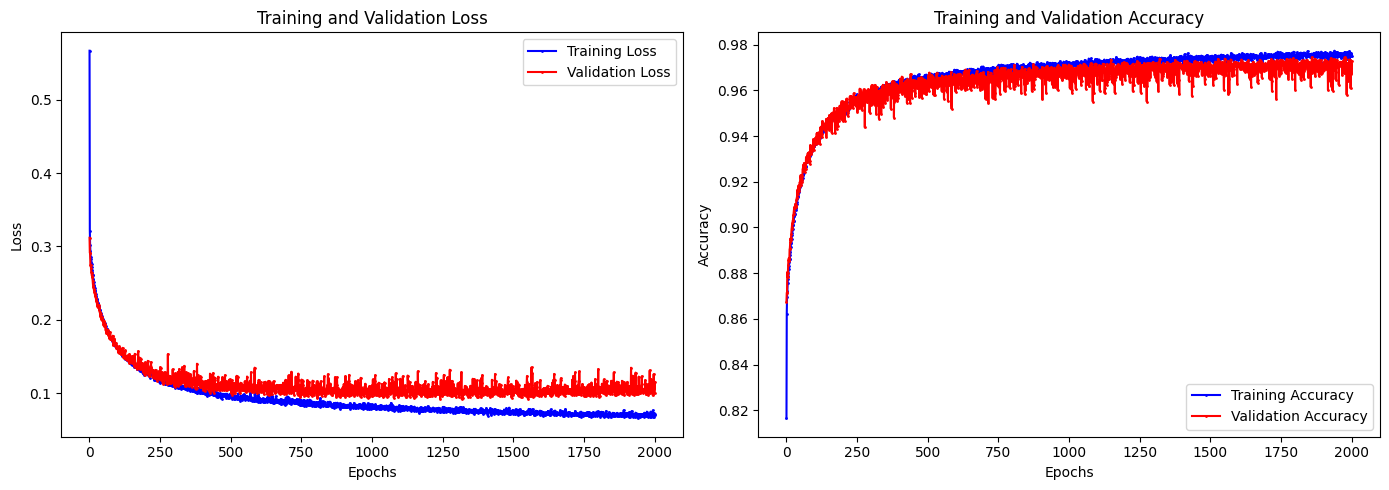

In [ ]:
import matplotlib.pyplot as plt
# Assuming 'history' is the return value from model.fit()
history_dict = history13.history

# Extracting loss and accuracy history
train_loss = history_dict['loss']
val_loss = history_dict['val_loss']
train_accuracy = history_dict['accuracy']
val_accuracy = history_dict['val_accuracy']

epochs = range(1, len(train_loss) + 1)

# Plotting training and validation loss
plt.figure(figsize=(14, 5))

# Training and validation loss plot
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, 'bo-', label='Training Loss', markersize=1)
plt.plot(epochs, val_loss, 'ro-', label='Validation Loss',markersize=1)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Training and validation accuracy plot
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracy, 'bo-', label='Training Accuracy', markersize=1)
plt.plot(epochs, val_accuracy, 'ro-', label='Validation Accuracy', markersize=1)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()  # Adjusts the plots to ensure they don't overlap
plt.show()

In [ ]:
import numpy as np

def print_best_val_loss_and_accuracy(history):
    history_dict = history13.history

    # Find the index of the best validation loss
    best_val_loss_index = np.argmin(history_dict['val_loss'])

    # Retrieve the best validation loss
    best_val_loss = history_dict['val_loss'][best_val_loss_index]

    # Retrieve the validation accuracy corresponding to the best validation loss
    best_val_accuracy = history_dict['val_accuracy'][best_val_loss_index]

    print(f"Best Validation Loss: {best_val_loss}")
    print(f"Validation Accuracy at Best Loss: {best_val_accuracy}")
    print(f"Best Val Loss Index: {best_val_loss_index}")

# Print the best validation loss and accuracy
print_best_val_loss_and_accuracy(history13)

Best Validation Loss: 0.09185776114463806
Validation Accuracy at Best Loss: 0.972398042678833
Best Val Loss Index: 1316


919/919 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step


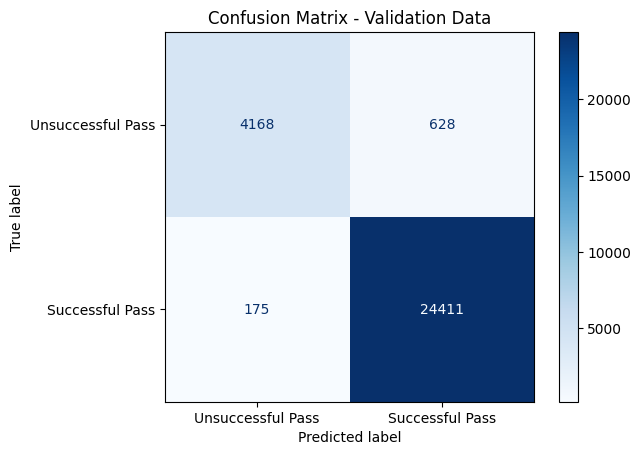

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Predict on validation data
val_predictions = attention_model.predict([val_p, val_f])
val_predictions = (val_predictions > 0.5).astype(int)  # Convert to binary predictions

# Generate confusion matrix
cm = confusion_matrix(val_y, val_predictions)

# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Unsuccessful Pass", "Successful Pass"])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix - Validation Data")
plt.show()

In [ ]:
history5 = attention_model.fit(
    train_ds,
    epochs=1000,
    validation_data=val_ds
)

Epoch 1/1000
406/406 ━━━━━━━━━━━━━━━━━━━━ 21s 37ms/step - accuracy: 0.8572 - loss: 0.5157 - val_accuracy: 0.9252 - val_loss: 0.2041
Epoch 2/1000
406/406 ━━━━━━━━━━━━━━━━━━━━ 14s 35ms/step - accuracy: 0.9266 - loss: 0.2097 - val_accuracy: 0.9311 - val_loss: 0.1821
Epoch 3/1000
406/406 ━━━━━━━━━━━━━━━━━━━━ 21s 37ms/step - accuracy: 0.9308 - loss: 0.1930 - val_accuracy: 0.9328 - val_loss: 0.1783
Epoch 4/1000
406/406 ━━━━━━━━━━━━━━━━━━━━ 14s 35ms/step - accuracy: 0.9336 - loss: 0.1848 - val_accuracy: 0.9352 - val_loss: 0.1730
Epoch 5/1000
406/406 ━━━━━━━━━━━━━━━━━━━━ 14s 35ms/step - accuracy: 0.9350 - loss: 0.1806 - val_accuracy: 0.9351 - val_loss: 0.1729
Epoch 6/1000
406/406 ━━━━━━━━━━━━━━━━━━━━ 14s 35ms/step - accuracy: 0.9370 - loss: 0.1766 - val_accuracy: 0.9366 - val_loss: 0.1667
Epoch 7/1000
406/406 ━━━━━━━━━━━━━━━━━━━━ 14s 35ms/step - accuracy: 0.9372 - loss: 0.1740 - val_accuracy: 0.9358 - val_loss: 0.1671
Epoch 8/1000
406/406 ━━━━━━━━━━━━━━━━━━━━ 14s 35ms/step - accuracy: 0.9373 -

901/901 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


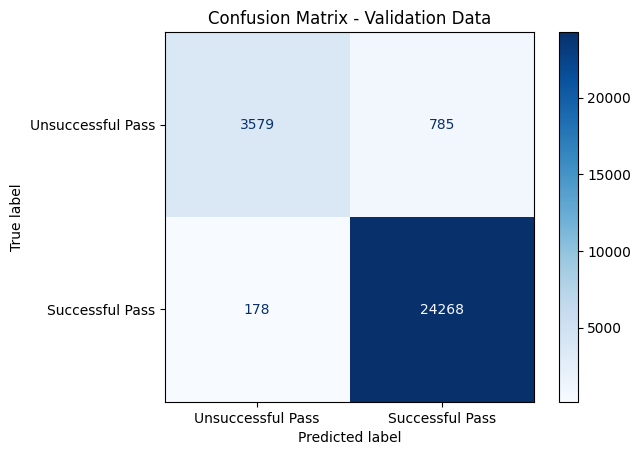

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Predict on validation data
val_predictions = attention_model.predict([val_p, val_f])
val_predictions = (val_predictions > 0.5).astype(int)  # Convert to binary predictions

# Generate confusion matrix
cm = confusion_matrix(val_y, val_predictions)

# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Unsuccessful Pass", "Successful Pass"])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix - Validation Data")
plt.show()

In [ ]:
history10 = attention_model.fit(
    train_ds,
    epochs=100,
    validation_data=val_ds
)

Epoch 1/100
280/280 ━━━━━━━━━━━━━━━━━━━━ 15s 35ms/step - accuracy: 0.8649 - loss: 0.5710 - val_accuracy: 0.9311 - val_loss: 0.1911
Epoch 2/100
280/280 ━━━━━━━━━━━━━━━━━━━━ 8s 27ms/step - accuracy: 0.9259 - loss: 0.2122 - val_accuracy: 0.9360 - val_loss: 0.1746
Epoch 3/100
280/280 ━━━━━━━━━━━━━━━━━━━━ 9s 34ms/step - accuracy: 0.9309 - loss: 0.1924 - val_accuracy: 0.9376 - val_loss: 0.1691
Epoch 4/100
280/280 ━━━━━━━━━━━━━━━━━━━━ 9s 32ms/step - accuracy: 0.9349 - loss: 0.1833 - val_accuracy: 0.9387 - val_loss: 0.1669
Epoch 5/100
280/280 ━━━━━━━━━━━━━━━━━━━━ 9s 29ms/step - accuracy: 0.9364 - loss: 0.1788 - val_accuracy: 0.9400 - val_loss: 0.1649
Epoch 6/100
280/280 ━━━━━━━━━━━━━━━━━━━━ 12s 34ms/step - accuracy: 0.9375 - loss: 0.1751 - val_accuracy: 0.9402 - val_loss: 0.1624
Epoch 7/100
280/280 ━━━━━━━━━━━━━━━━━━━━ 10s 34ms/step - accuracy: 0.9378 - loss: 0.1721 - val_accuracy: 0.9403 - val_loss: 0.1619
Epoch 8/100
280/280 ━━━━━━━━━━━━━━━━━━━━ 8s 29ms/step - accuracy: 0.9377 - loss: 0.1708

## MODEL PRED - Test data


In [ ]:
# Mount Google Drive
drive.mount('/content/gdrive')

# Load the dataset (Excel file)
file_path = "/content/gdrive/MyDrive/fixedtestdatav12.csv"
test_df = pd.read_csv(file_path)



Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
model = keras.models.load_model("/content/gdrive/My Drive/best_modelfixeddatav13.keras")

In [ ]:
import numpy as np
import ast

# Create the pass feature vector
test_df['pass_features'] = test_df.apply(
    lambda row: list(ast.literal_eval(row['start_coordinates'])) +
                list((row['intended_end_coordinates'])) + # removed ast.literal_eval when using intended_end_coordinates
                [row['pass_distance']] +
                [row['pass_angle']] +
                [row['pressure_distance_passer']] +
                [row['pressure_distance_receiver']] +
                [row['num_opponents_near_trajectory']],
    axis=1
)

# The 'player_matrix' column likely already contains NumPy arrays
test_df['player_matrix_array'] = test_df['player_matrix'].apply(lambda x: np.array(ast.literal_eval(x)) if isinstance(x, str) else np.array(x))

# Pad shorter arrays with zeros to match the maximum shape
max_players = 22  # Expected number of players
padded_matrices = [
    np.pad(arr, ((0, max_players - arr.shape[0]), (0, 0)), 'constant')
    if arr.shape[0] < max_players else arr
    for arr in test_df['player_matrix_array']
]

# Stack player matrices and pass features into NumPy arrays
player_matrices = np.stack(padded_matrices)  # Shape: (num_samples, 22, 4)
pass_features = np.stack(test_df['pass_features'].values)          # Shape: (num_samples, 9)

# Target variable (0 or 1)
targets = test_df['result_id'].values

In [ ]:
predictions = model.predict([player_matrices, pass_features])


919/919 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step


In [ ]:
# Assuming predictions is a NumPy array of shape (n_samples, 1)
test_df['predicted_prob'] = predictions.flatten()
test_df['predicted_class'] = (test_df['predicted_prob'] > 0.5).astype(int)


In [ ]:
test_df.to_csv("/content/gdrive/My Drive/Riskv13.csv")

In [ ]:
# Load the dataset (Excel file)
file_path = "/content/gdrive/My Drive/Riskv13.csv"
test_df = pd.read_csv(file_path)

In [ ]:
false_positives_at_1 = test_df[(test_df['predicted_prob'] == 1) & (test_df['result_id'] == 0)]

print(false_positives_at_1)
print(f"Total rows with predicted_prob == 1 and result_id == 0: {len(false_positives_at_1)}")


       Unnamed: 0  game_id  original_event_id  player_id       player_name starting_position start_coordinates end_coordinates                           intended_end_coordinates  pass_distance  \
367        117757  2437686         2692286617     244449   Mikael Anderson        Midfielder      (92.7, 78.1)     (84.6, 0.0)  (np.float64(57.72131147540984), np.float64(-1....         86.543   
6209        96359  2367368         2583654105     208766     Patrick Pentz        Goalkeeper      (13.4, 41.7)    (19.8, 36.5)  (np.float64(14.735), np.float64(36.00072727272...          5.854   
9405        70057  2367434         2624470323     449904  Oliver Villadsen          Defender      (58.2, 62.4)    (34.5, 53.6)  (np.float64(37.34176278563656), np.float64(51....         23.381   
26317       28650  2367373         2586460755     543224    Anosike Ementa           Striker       (40.1, 7.4)    (78.1, 92.2)  (np.float64(29.70351409978308), np.float64(68....         61.973   
28527       71038  2

In [ ]:
# Class distribution
print(test_df['predicted_class'].value_counts())

# Average predicted probability by true class (if you have labels)
if 'result_id' in test_df.columns:
    print(test_df.groupby('result_id')['predicted_prob'].describe())


predicted_class
1    24871
0     4512
Name: count, dtype: int64
              count  mean   std   min   25%   50%   75%   max
result_id                                                    
0          4852.000 0.131 0.269 0.000 0.000 0.007 0.068 1.000
1         24531.000 0.976 0.088 0.000 0.988 0.998 1.000 1.000


In [ ]:
for thresh in [0.9, 0.95, 0.99, 1.0]:
    count = test_df[(test_df['result_id'] == 0) & (test_df['predicted_prob'] >= thresh)].shape[0]
    print(f"False positives with prob ≥ {thresh}: {count}")


False positives with prob ≥ 0.9: 234
False positives with prob ≥ 0.95: 159
False positives with prob ≥ 0.99: 56
False positives with prob ≥ 1.0: 5


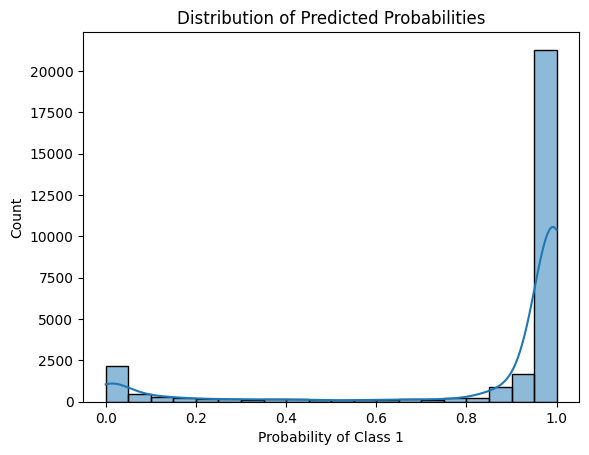

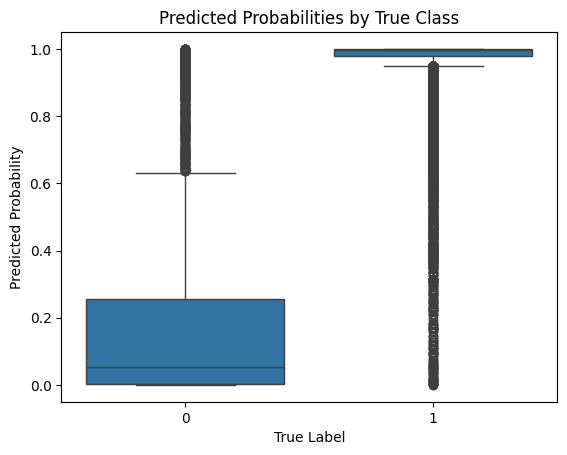

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Distribution of predicted probabilities
sns.histplot(test_df['predicted_prob'], bins=20, kde=True)
plt.title("Distribution of Predicted Probabilities")
plt.xlabel("Probability of Class 1")
plt.ylabel("Count")
plt.show()

# Probability by true class (if labels are available)
if 'result_id' in test_df.columns:
    sns.boxplot(x='result_id', y='predicted_prob', data=test_df)
    plt.title("Predicted Probabilities by True Class")
    plt.xlabel("True Label")
    plt.ylabel("Predicted Probability")
    plt.show()


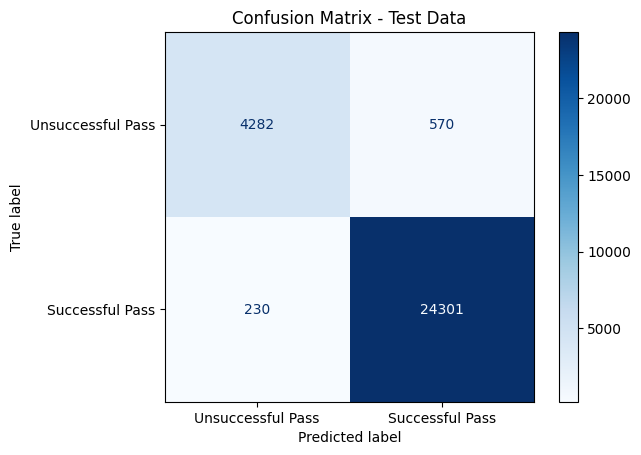

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Extract true and predicted labels
true_labels = test_df['result_id']
predicted_labels = test_df['predicted_class']

# Generate confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Unsuccessful Pass", "Successful Pass"])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix - Test Data")
plt.show()


In [ ]:
from sklearn.metrics import classification_report, roc_auc_score

if 'result_id' in test_df.columns:
    print(classification_report(test_df['result_id'], test_df['predicted_class']))
    print("ROC AUC:", roc_auc_score(test_df['result_id'], test_df['predicted_prob']))


              precision    recall  f1-score   support

           0       0.95      0.88      0.91      4852
           1       0.98      0.99      0.98     24531

    accuracy                           0.97     29383
   macro avg       0.96      0.94      0.95     29383
weighted avg       0.97      0.97      0.97     29383

ROC AUC: 0.986644538096941


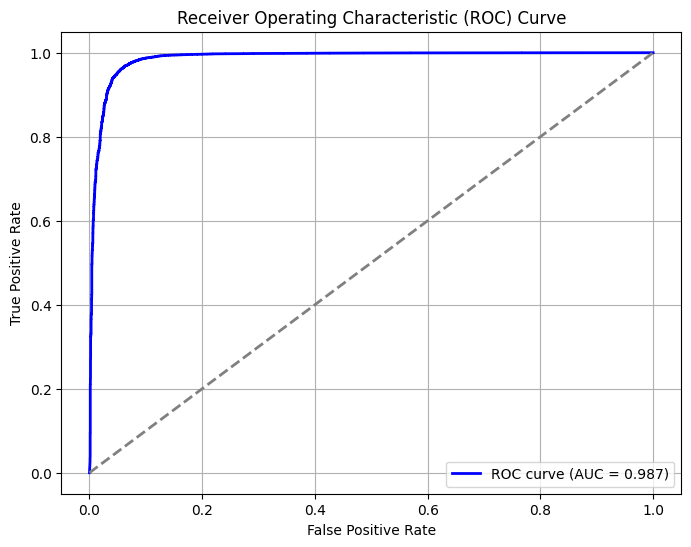

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Extract true labels and predicted probabilities
true_labels = test_df['result_id']
predicted_probs = test_df['predicted_prob']

# Calculate the ROC curve
fpr, tpr, thresholds = roc_curve(true_labels, predicted_probs)

# Calculate the AUC score
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')  # Random chance line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()
